# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]
    
## Problem Statements:
- Which areas have high / low traffic demand?
- How does regional traffic demand change according to day / time?
- Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### This is dataset features generation 
- Feature Engineering

#### Import python library

In [74]:
import pandas as pd   # for reading datasets
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler # for encoding geohash and data normalisation
import matplotlib.pyplot as plt # for Chart ploting

# to scale the data
from sklearn.preprocessing import StandardScaler
import joblib # for saving scaler

# For Clustering check
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import geohash as gh     # for geohash conversion
try:
    import _geohash
except ImportError:
    _geohash = None

### Define Function

In [75]:
#=========================================================================
# Function to Check on data spread and Normality
#=========================================================================

def Normality_Check(feature):
    
    subtitle = feature + ' Data'
    title1 = feature + " Count"
    title2 = feature + ' Spread'
    filename = feature + '_normality_check.png'
    
    # Ploting two figure side by side
    fig = plt.figure(figsize=(60,20)) #  figure
    fig.suptitle(subtitle, fontsize=40, fontweight='bold')
    ax1 = fig.add_subplot(121)
    
    ax1.set_title(title1, fontsize=30)
    ax1.xaxis.set_tick_params(labelsize=30)
    ax1.yaxis.set_tick_params(labelsize=30)
    ax2 = fig.add_subplot(122)
    
    ax2.set_title(title2, fontsize=30)
    ax2.xaxis.set_tick_params(labelsize=30)
    ax2.yaxis.set_tick_params(labelsize=30)

    plt.subplot(121) # 1st figure
    df[feature].hist(bins=50)

    plt.subplot(122) # 2nd figure
    df.boxplot(column=feature)
    # Save the chart to file
    plt.savefig(filename, bbox_inches="tight")

# normalisation of data
def norm(x,train_stats):
    mean = train_stats['mean']
    std  = train_stats['std']
    
    normalisation = pd.concat([mean, std], axis=1, sort=False) 
    
    # save mean & std for inference data
    writer = pd.ExcelWriter('data/normalisation_mean_std.xlsx', engine='xlsxwriter')
    normalisation.to_excel(writer, sheet_name='Normalised', index=True)

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    
    return (x - mean) / std

#### Reading from training dataset

In [76]:
predictor_var = ['day', 'hour', 'min', 'lat', 'long']
outcome_var   = 'demand'

In [77]:
df = pd.read_csv("data/training.csv")
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:00,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:00,0.088755
4,qp090q,15,4:00,0.074468


- Read dataset metric data statistics
- Check for data integrity

In [78]:
# As can see from the summary, all the features has different range
df.describe(include='all')

,geohash6,day,timestamp,demand
count,1048575,1.048575e+06,1048575,1.048575e+06
unique,1314,NaN,96,NaN
top,qp03r3,NaN,9:00,NaN
freq,1534,NaN,14397,NaN
mean,NaN,3.146812e+01,NaN,1.048976e-01
std,NaN,1.767886e+01,NaN,1.588668e-01
min,NaN,1.000000e+00,NaN,3.040000e-08
25%,NaN,1.600000e+01,NaN,1.869865e-02
50%,NaN,3.200000e+01,NaN,5.046788e-02
75%,NaN,4.700000e+01,NaN,1.204841e-01


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   geohash6   1048575 non-null  object 
 1   day        1048575 non-null  int64  
 2   timestamp  1048575 non-null  object 
 3   demand     1048575 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [80]:
# check how many days of data
print("There are total {} days".format(len(df["day"].unique())))
np.sort(df["day"].unique())

There are total 61 days


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=int64)

In [81]:
# check number of unique timestamp
print("There are total {} timestamp".format(len(df["timestamp"].unique())))
np.sort(df["timestamp"].unique())

There are total 96 timestamp


array(['0:00', '0:15', '0:30', '0:45', '10:00', '10:15', '10:30', '10:45',
       '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30',
       '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15',
       '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00',
       '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45',
       '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30',
       '19:45', '1:00', '1:15', '1:30', '1:45', '20:00', '20:15', '20:30',
       '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15',
       '22:30', '22:45', '23:00', '23:15', '23:30', '23:45', '2:00',
       '2:15', '2:30', '2:45', '3:00', '3:15', '3:30', '3:45', '4:00',
       '4:15', '4:30', '4:45', '5:00', '5:15', '5:30', '5:45', '6:00',
       '6:15', '6:30', '6:45', '7:00', '7:15', '7:30', '7:45', '8:00',
       '8:15', '8:30', '8:45', '9:00', '9:15', '9:30', '9:45'],
      dtype=object)

### Which areas have high / low traffic demand?

In [82]:
# In order to know visually which area is in high demand need to know the unque geohash has 
# the higher numbers of count
geohashes_group = df.groupby("geohash6", as_index=False)\
.agg({"day":"count"})\
.rename(columns={"day":"count"})\
.sort_values(by="count", ascending=False)

In [83]:
geohashes_group

,geohash6,count
141,qp03r3,1534
631,qp096t,1530
502,qp092m,1526
637,qp096z,1523
628,qp096q,1515
...,...,...
1247,qp0d5n,1
825,qp09eg,1
966,qp09kg,1
1002,qp09mv,1


In [84]:
geohashes_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1314 entries, 141 to 984
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   geohash6  1314 non-null   object
 1   count     1314 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.8+ KB


In [86]:
geohashes_group[['lat','long']] = geohashes_group['geohash6'].apply(lambda x: pd.Series(gh.decode(x)))
geohashes_group

,geohash6,count,lat,long
141,qp03r3,1534,-5.397034,90.675659
631,qp096t,1530,-5.375061,90.818481
502,qp092m,1526,-5.375061,90.719604
637,qp096z,1523,-5.364075,90.829468
628,qp096q,1515,-5.369568,90.807495
...,...,...,...,...
1247,qp0d5n,1,-5.237732,90.840454
825,qp09eg,1,-5.342102,90.873413
966,qp09kg,1,-5.386047,90.917358
1002,qp09mv,1,-5.375061,90.961304


#### Create geohash cluster

In [87]:
# For proper clustering , is best to convert the lat and long data to standard scaling
# Create a temp lat-long data for clustering check
latlong = geohashes_group[["lat", "long"]].values
latlong = np.nan_to_num(latlong) # In case any too small or large number generated
latlong = StandardScaler().fit_transform(latlong)

print(latlong.shape)
latlong

(1314, 2)


array([[-0.70650955, -1.03046278],
       [-0.37229893,  0.30123378],
       [-0.37229893, -0.62070999],
       ...,
       [-0.53940424,  1.22317756],
       [-0.37229893,  1.63293034],
       [-0.62295689,  1.42805395]])

- use two methods to check for clustering
  - Silhouette Coefficient
  - KMeans Elbow method

In [88]:
# Silhouette Coefficient: Combines both the Cohesion and Separation
score = []
results = []
values = np.arange(2, 80)

for n_cluster in values:
    kmeans = KMeans(n_clusters=n_cluster).fit(latlong)
    label = kmeans.labels_
    # get inertia
    inertia = kmeans.inertia_
    sil_coeff = silhouette_score(latlong, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    score.append(sil_coeff)
    # add results to list
    results.append({'n':n_cluster, 'sil_coef':sil_coeff, 'inertia':inertia})

For n_clusters=2, The Silhouette Coefficient is 0.3537768436460174
For n_clusters=3, The Silhouette Coefficient is 0.3886239202353945
For n_clusters=4, The Silhouette Coefficient is 0.3906295108084326
For n_clusters=5, The Silhouette Coefficient is 0.36854443264769526
For n_clusters=6, The Silhouette Coefficient is 0.3867025555572703
For n_clusters=7, The Silhouette Coefficient is 0.38684628605029525
For n_clusters=8, The Silhouette Coefficient is 0.3717063892005739
For n_clusters=9, The Silhouette Coefficient is 0.3679311326535662
For n_clusters=10, The Silhouette Coefficient is 0.36004047442483506
For n_clusters=11, The Silhouette Coefficient is 0.3608436409985154
For n_clusters=12, The Silhouette Coefficient is 0.3640843138244086
For n_clusters=13, The Silhouette Coefficient is 0.36401977682001196
For n_clusters=14, The Silhouette Coefficient is 0.35768940023370954
For n_clusters=15, The Silhouette Coefficient is 0.35608713262692404
For n_clusters=16, The Silhouette Coefficient is 0

Text(0.5, 1.0, 'Silhouette score vs number of clusters')

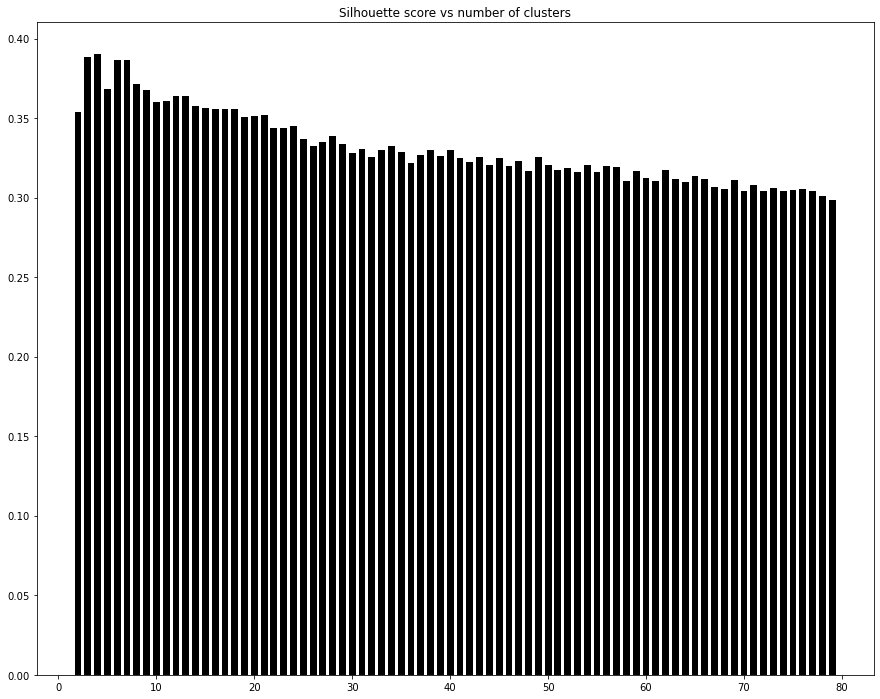

In [89]:
# Visualize the silhouette scores for various values:
# Plot silhouette scores

plt.figure(figsize=(15,12))
plt.bar(values, score, width=0.7, color='black', align='center')
plt.title('Silhouette score vs number of clusters')

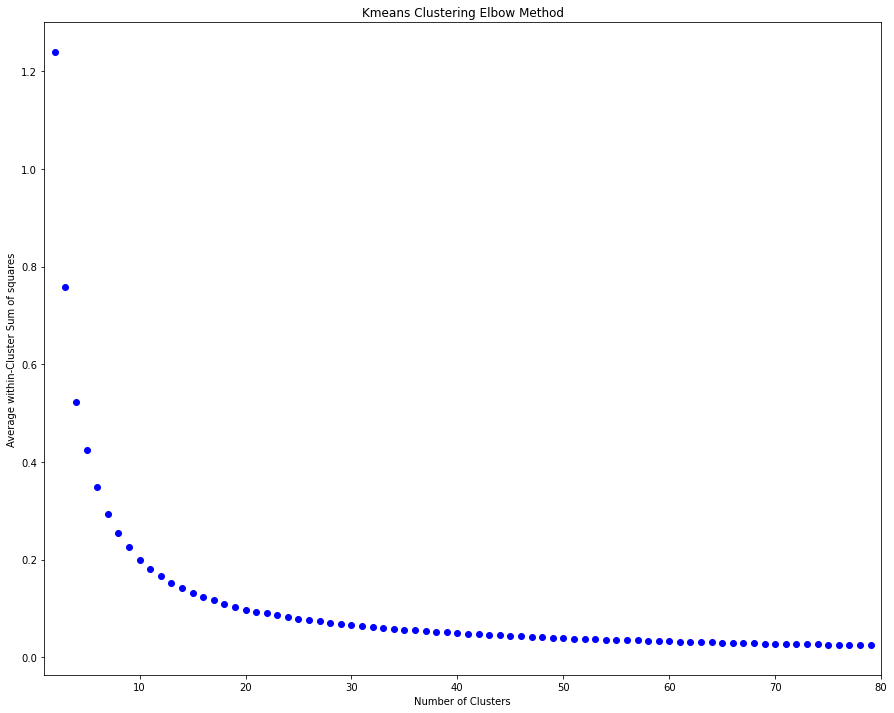

In [90]:
# KMeans Elbow method

A = []
B = []

for i in range (2 , 80):
    # fit a Kmeans model to the data
    model = KMeans(init='k-means++',n_clusters=i, n_init=10)
    model.fit(latlong)
    
    # Append number of cluster to A data list
    A.append(i)
    
    # Append average within cluster sum of squares to B data List
    SSE = model.inertia_/ latlong.shape[0]
    B.append(SSE)

# plot A & B
plt.figure(figsize=(15,12))
plt.plot(A,B,'bo')
plt.xlim((1,80))
plt.xlabel('Number of Clusters')
plt.ylabel('Average within-Cluster Sum of squares')
plt.title('Kmeans Clustering Elbow Method')

# Display the plot
plt.show()

**Note:** Since the tapping off is around 50 to 60, I will choose k=50 to cluster the locations

In [91]:
# fit a Kmeans model to the data
KMeans_model = KMeans(init='k-means++',n_clusters=50, n_init=10)
KMeans_model.fit(latlong)
cluster_centers = KMeans_model.cluster_centers_
labels = KMeans_model.labels_
print(KMeans_model)

KMeans(n_clusters=50)


In [92]:
labels

array([20, 47, 44, ..., 31, 19, 46])

In [93]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [94]:
# assign the labels back to the dataset
geohashes_group["geo_cluster"] = labels

In [95]:
geohashes_group.head(12)

,geohash6,count,lat,long,geo_cluster
141,qp03r3,1534,-5.397034,90.675659,20
631,qp096t,1530,-5.375061,90.818481,47
502,qp092m,1526,-5.375061,90.719604,44
637,qp096z,1523,-5.364075,90.829468,47
628,qp096q,1515,-5.369568,90.807495,47
815,qp09e5,1515,-5.342102,90.840454,25
865,qp09ft,1511,-5.287170,90.818481,48
144,qp03r6,1511,-5.391541,90.675659,0
247,qp03xf,1510,-5.347595,90.697632,10
675,qp0985,1509,-5.342102,90.708618,10


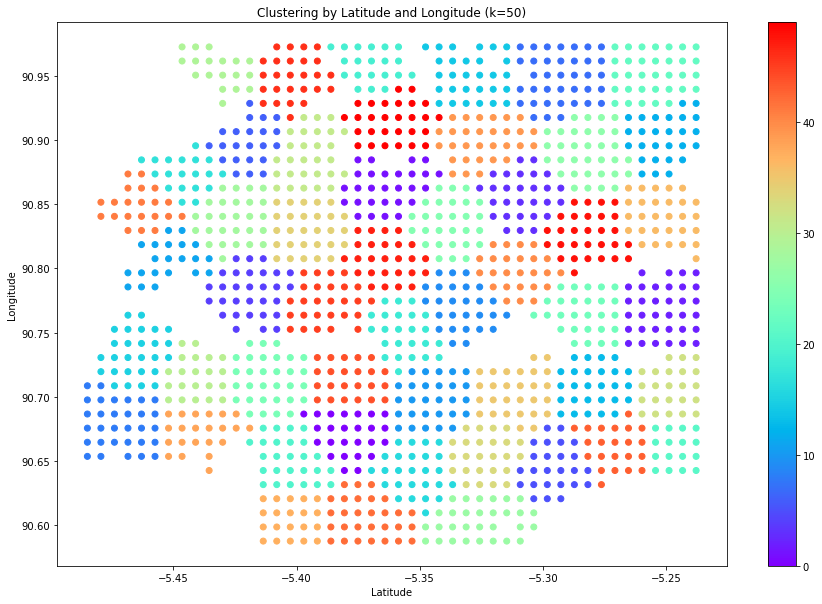

In [96]:
# Visualisation of the cluster labels
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(geohashes_group["lat"], geohashes_group["long"], c=geohashes_group["geo_cluster"], cmap="rainbow")
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Clustering by Latitude and Longitude (k=50)")
plt.savefig("geohash_region_clustering.png", bbox_inches="tight")
plt.show()

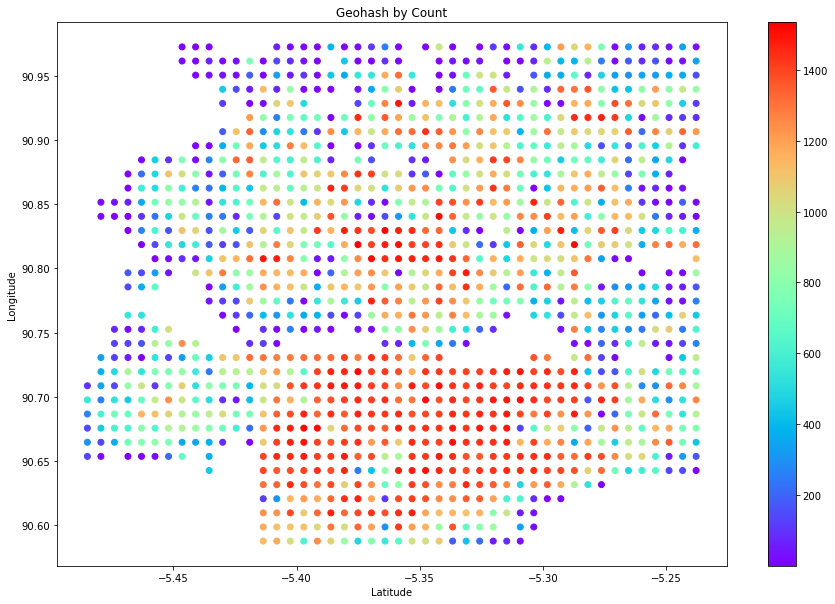

In [97]:
# Visualisation of the geohash count labels
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(geohashes_group["lat"], geohashes_group["long"], c=geohashes_group["count"], cmap="rainbow")
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Geohash by Count")
plt.savefig("geohash_Count_clustering.png", bbox_inches="tight")
plt.show()

In [98]:
sort_by_demand = df.sort_values(['demand'],ascending = True)
sort_by_demand.head(10)

,geohash6,day,timestamp,demand
743542,qp0d4t,41,18:30,3.040000e-08
1002422,qp03t6,30,11:30,1.220000e-07
547170,qp0d0j,49,16:30,2.360000e-07
794912,qp099j,60,3:00,2.760000e-07
213151,qp03mq,37,15:15,3.140000e-07
32674,qp09tk,5,12:30,3.870000e-07
1046833,qp08b7,2,7:45,4.290000e-07
848945,qp06n8,34,9:00,5.820000e-07
451370,qp09cf,3,23:15,6.420000e-07
975835,qp09hh,54,20:15,7.030000e-07


In [99]:
sort_by_demand = df.sort_values(['demand'],ascending = False)
sort_by_demand.head(10)

,geohash6,day,timestamp,demand
863013,qp09d2,51,12:30,1.0
627960,qp03xx,60,16:45,1.0
369077,qp096x,23,6:00,1.0
784083,qp09d9,6,12:00,1.0
877720,qp09uy,6,12:00,1.0
66025,qp02zw,51,8:30,1.0
13900,qp03wz,40,9:15,1.0
36697,qp03xw,2,11:30,1.0
332462,qp03xw,12,9:45,1.0
907111,qp03xm,40,7:15,1.0


- Seems like the most geohash counts are:
    - between latitude -5.4 to -5.3 
    - between longitude 90.6 to 90.75
    - Does that means more count = to more demand ?
    - with the evidence from the sort by lowest demand value that some coninsides with the same area
    - with the evidence from the sort by highest demand value that some coninsides with the same area

### Feature Engineering for the DNN Model

#### Extract hour and minute from timestamp column and Day of Week (dow)

In [100]:
# Extract hour and min from timestamp
df[['hour','min']] = df['timestamp'].str.split(':',expand=True)
df['hour'] = df['hour'].astype('int64')
df['min'] = df['min'].astype('int64')

#### Convert geohash to Lat & long

In [101]:
df[['lat','long']] = df['geohash6'].apply(lambda x: pd.Series(gh.decode(x)))
df.head(30)

,geohash6,day,timestamp,demand,hour,min,lat,long
0,qp03wc,18,20:00,0.020072,20,0,-5.353088,90.653687
1,qp03pn,10,14:30,0.024721,14,30,-5.413513,90.664673
2,qp09sw,9,6:15,0.102821,6,15,-5.325623,90.906372
3,qp0991,32,5:00,0.088755,5,0,-5.353088,90.752563
4,qp090q,15,4:00,0.074468,4,0,-5.413513,90.719604
5,qp03tu,1,12:15,0.023843,12,15,-5.336609,90.609741
6,qp096d,25,3:30,0.007460,3,30,-5.391541,90.818481
7,qp03nr,51,20:45,0.000293,20,45,-5.408020,90.631714
8,qp093r,48,6:15,0.054170,6,15,-5.364075,90.763550
9,qp03r2,4,22:15,0.123463,22,15,-5.402527,90.675659


#### Drop unused features

In [102]:
# Drop original column timestamp and geohash
# Since we have already converted both timestamp and geohash into more detail features
df.drop(columns=['geohash6', 'timestamp'], inplace=True)
df = df[['day', 'hour', 'min', 'lat', 'long','demand']]
df = df.sort_values(['day','hour','min']).reset_index(drop=True)
df

,day,hour,min,lat,long,demand
0,1,0,0,-5.320129,90.906372,0.021212
1,1,0,0,-5.254211,90.917358,0.013217
2,1,0,0,-5.342102,90.664673,0.157956
3,1,0,0,-5.281677,90.730591,0.001262
4,1,0,0,-5.325623,90.620728,0.032721
...,...,...,...,...,...,...
1048570,61,23,45,-5.353088,90.664673,0.041818
1048571,61,23,45,-5.364075,90.774536,0.061371
1048572,61,23,45,-5.325623,90.774536,0.005397
1048573,61,23,45,-5.429993,90.796509,0.001453


#### Save sample for testing later

In [103]:
start_sample = 8000
end_sample   = 8021
test_sample  = df[start_sample:end_sample]
test_sample

,day,hour,min,lat,long,demand
8000,1,9,15,-5.391541,90.620728,0.088232
8001,1,9,15,-5.375061,90.697632,0.129917
8002,1,9,15,-5.402527,90.752563,0.017999
8003,1,9,30,-5.408020,90.884399,0.053128
8004,1,9,30,-5.353088,90.664673,0.108126
8005,1,9,30,-5.353088,90.774536,0.031724
8006,1,9,30,-5.364075,90.697632,0.082523
8007,1,9,30,-5.303650,90.719604,0.641914
8008,1,9,30,-5.309143,90.697632,0.137389
8009,1,9,30,-5.270691,90.829468,0.207882


In [104]:
writer = pd.ExcelWriter('data/test_sample_sorted_8000.xlsx', engine='xlsxwriter')
test_sample.to_excel(writer, sheet_name='TrafficMgmt', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

#### normalize features

In [105]:
train_stats = df[predictor_var].describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
day,1048575.0,31.468115,17.678858,1.000000,16.000000,32.000000,47.00000,61.000000
hour,1048575.0,9.815705,6.540293,0.000000,4.000000,9.000000,14.00000,23.000000
min,1048575.0,22.456977,16.781047,0.000000,0.000000,15.000000,30.00000,45.000000
lat,1048575.0,-5.347456,0.056705,-5.484924,-5.391541,-5.347595,-5.30365,-5.237732
long,1048575.0,90.764195,0.102737,90.587769,90.675659,90.752563,90.85144,90.972290


In [106]:
y = df['demand']
df[['day','hour','min','lat','long']] = norm(df[['day','hour','min','lat','long']],train_stats)

In [107]:
df

,day,hour,min,lat,long,demand
0,-1.723421,-1.500805,-1.338235,0.481907,1.383892,0.021212
1,-1.723421,-1.500805,-1.338235,1.644371,1.490828,0.013217
2,-1.723421,-1.500805,-1.338235,0.094420,-0.968706,0.157956
3,-1.723421,-1.500805,-1.338235,1.160011,-0.327088,0.001262
4,-1.723421,-1.500805,-1.338235,0.385035,-1.396451,0.032721
...,...,...,...,...,...,...
1048570,1.670463,2.015857,1.343362,-0.099324,-0.968706,0.041818
1048571,1.670463,2.015857,1.343362,-0.293068,0.100657,0.061371
1048572,1.670463,2.015857,1.343362,0.385035,0.100657,0.005397
1048573,1.670463,2.015857,1.343362,-1.455532,0.314530,0.001453


#### Check for data Normality

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


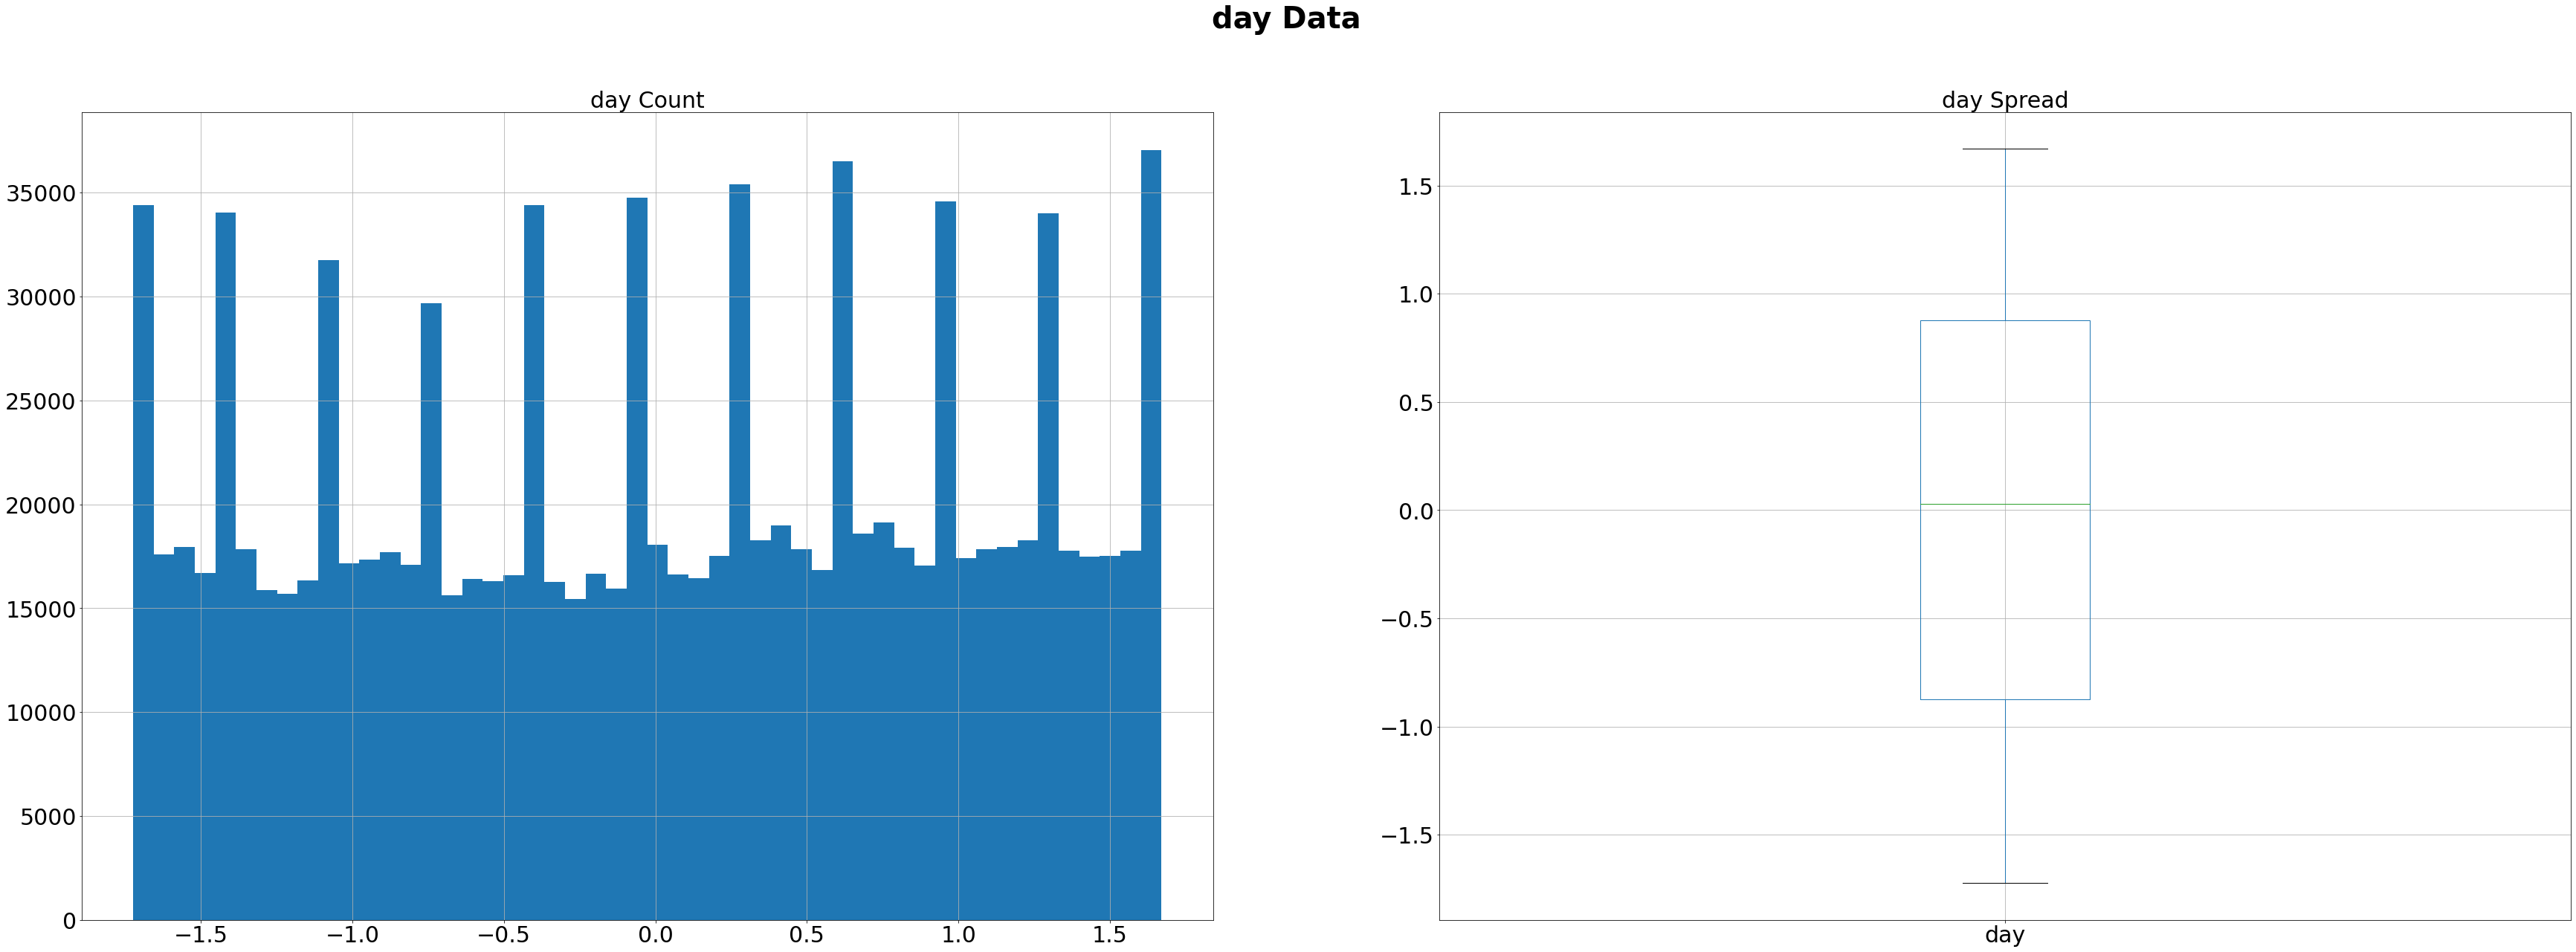

In [108]:
Normality_Check('day')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


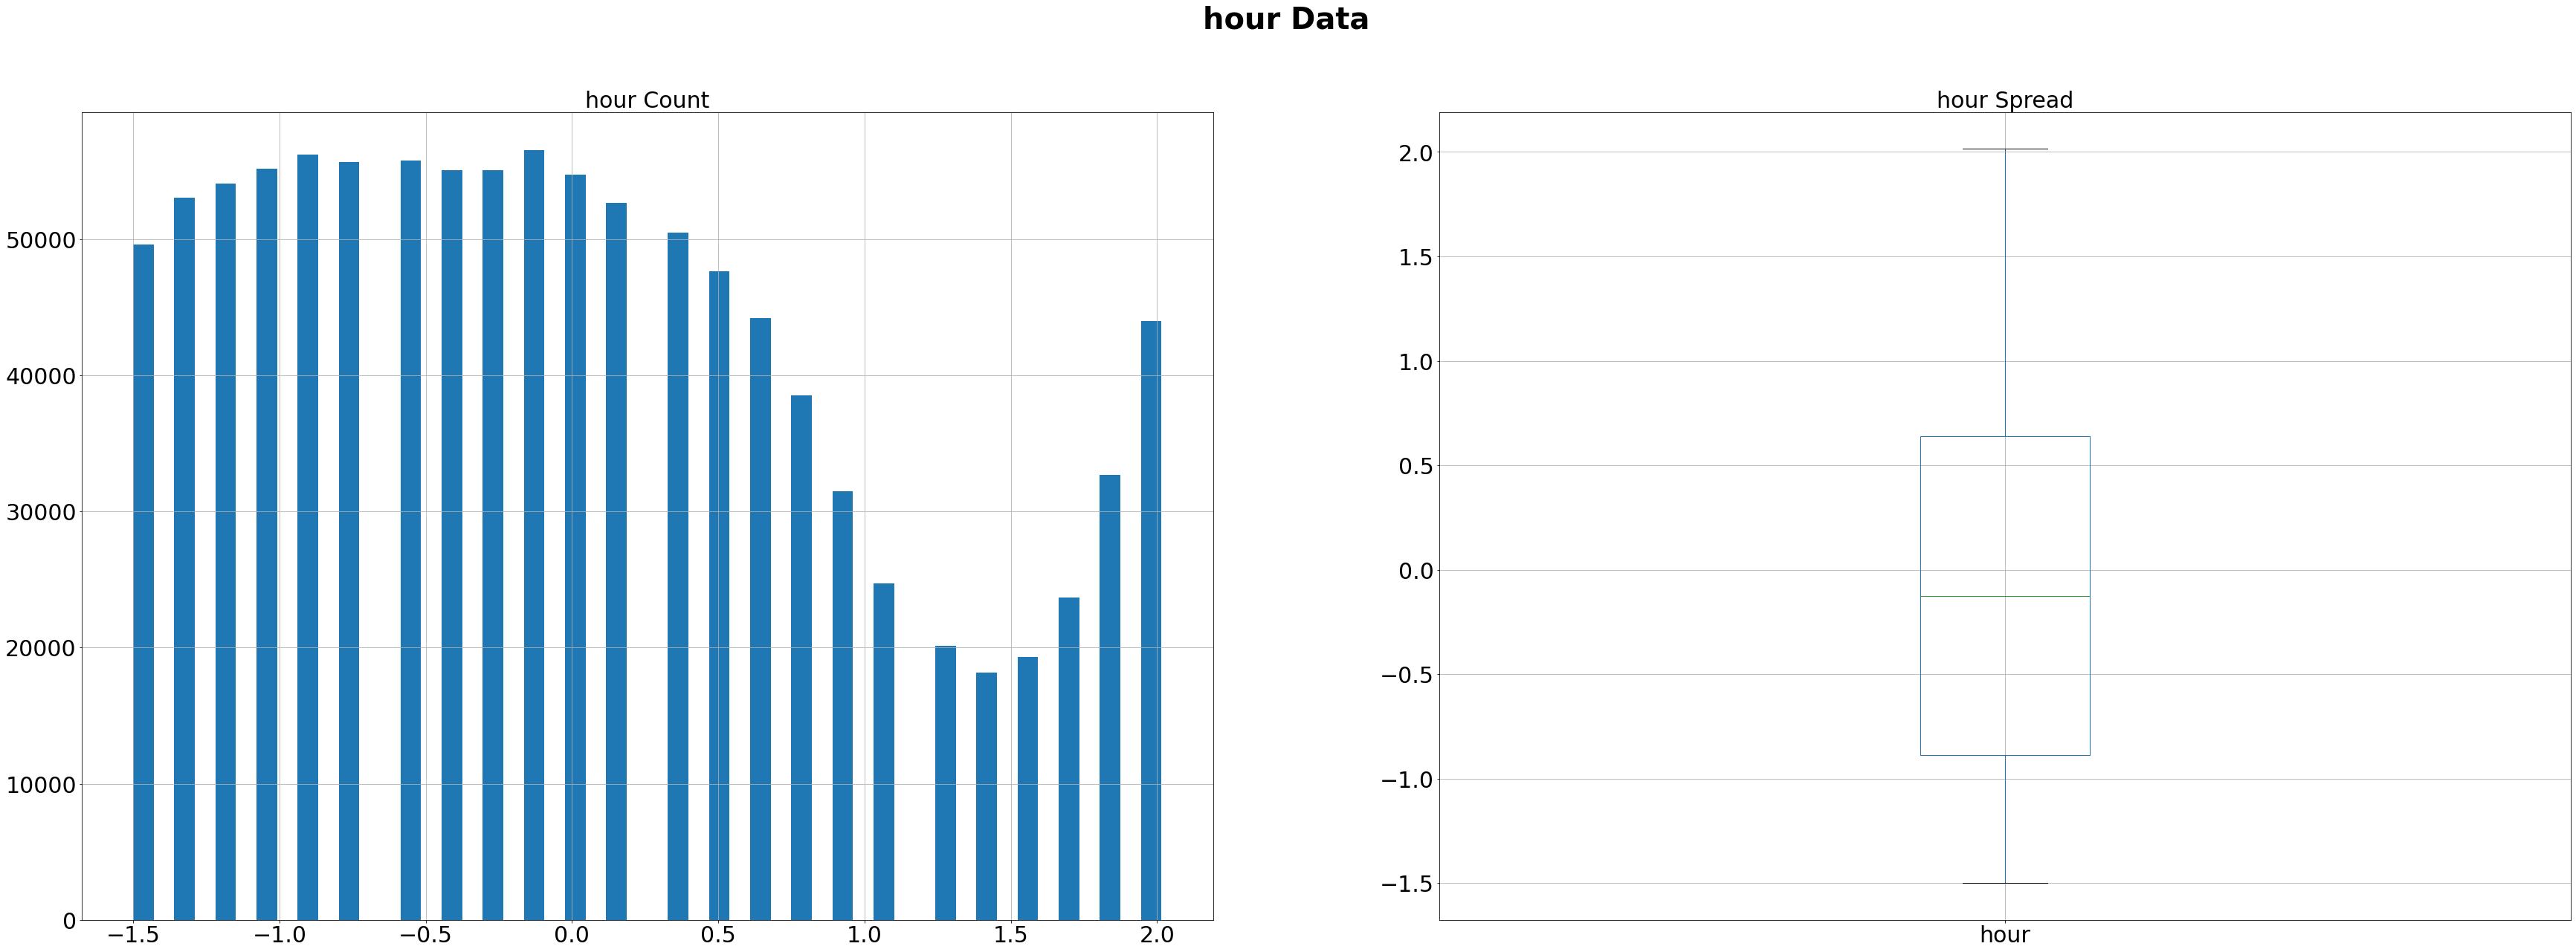

In [109]:
Normality_Check('hour')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


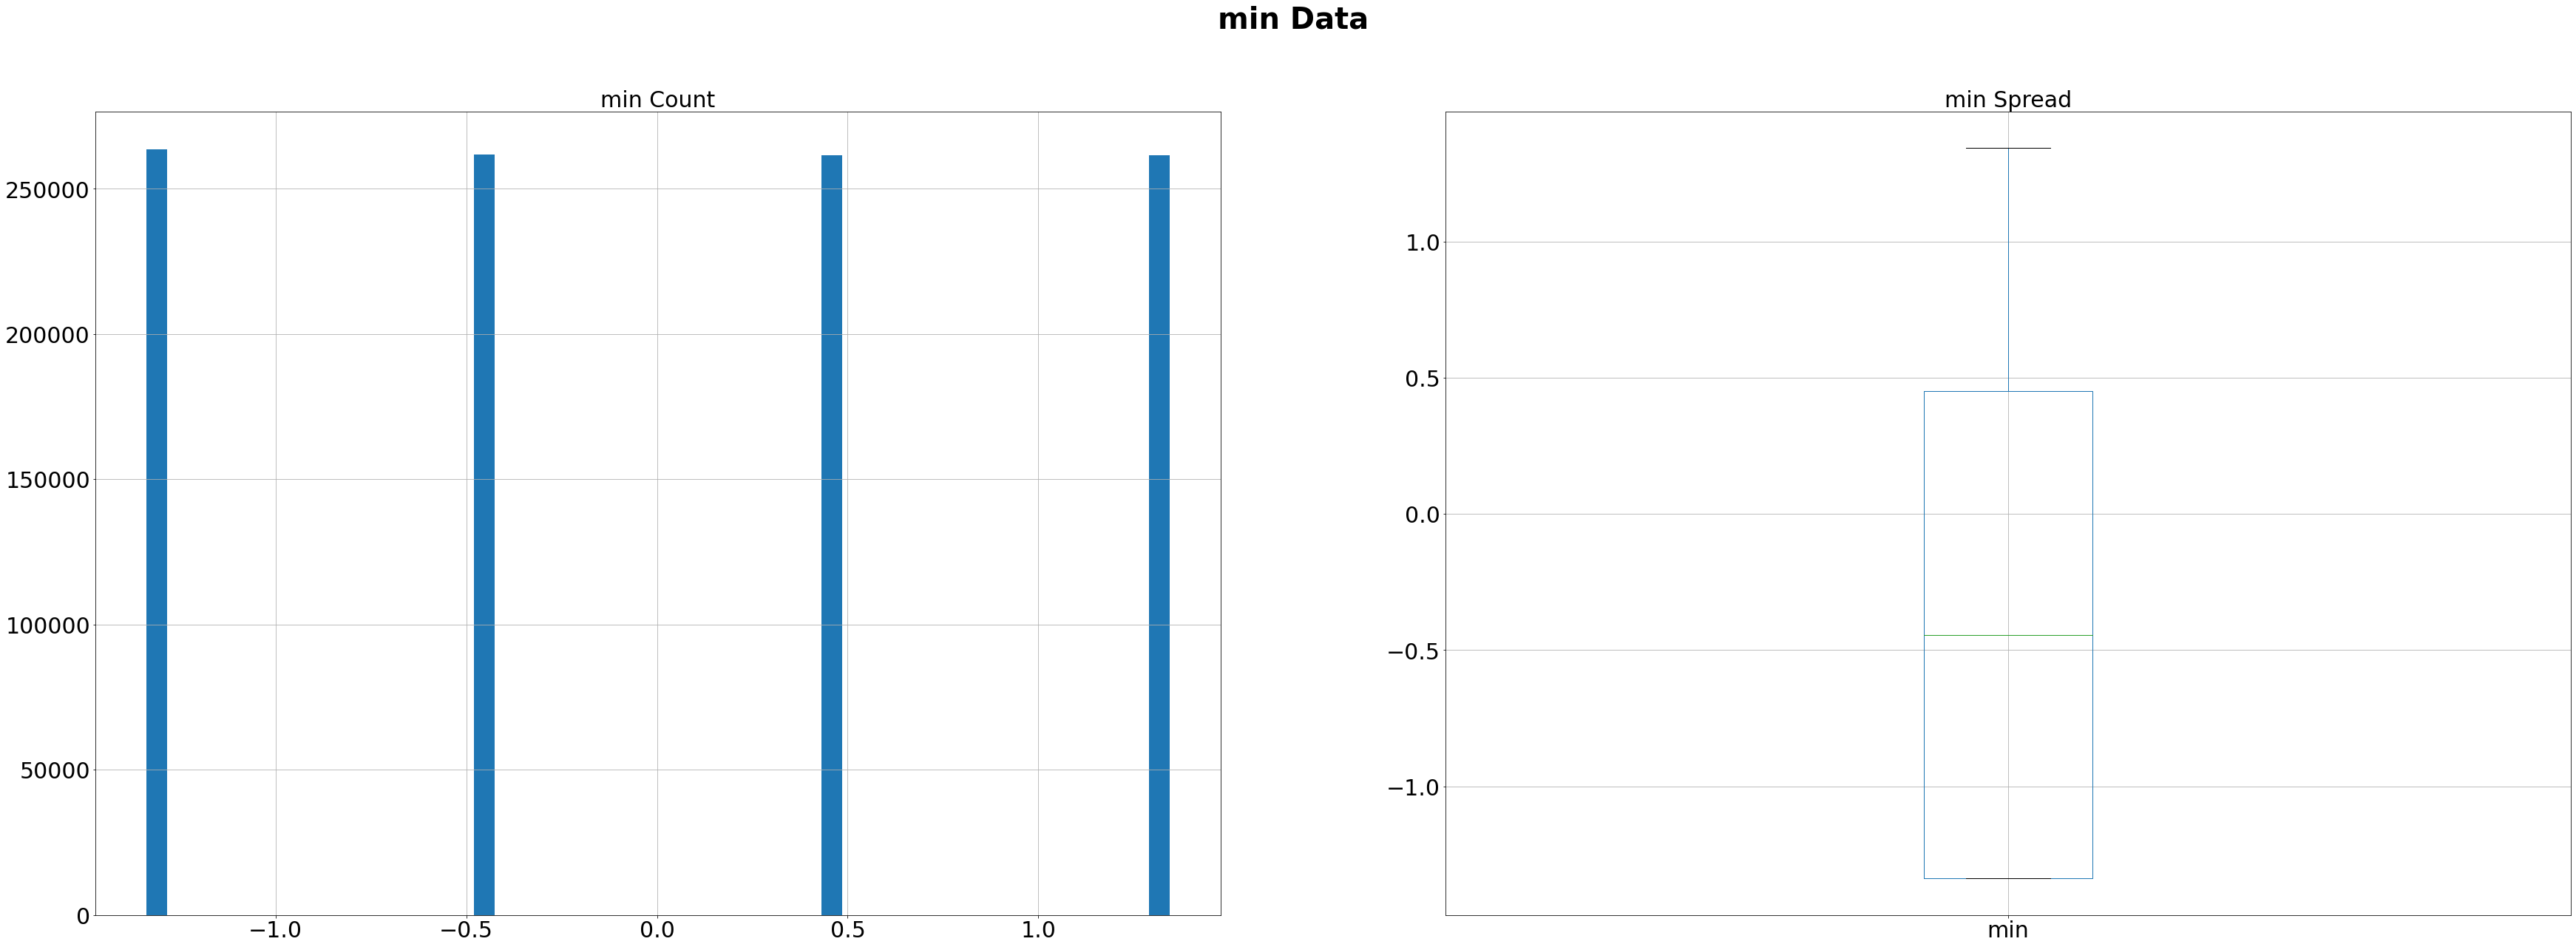

In [110]:
Normality_Check('min')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


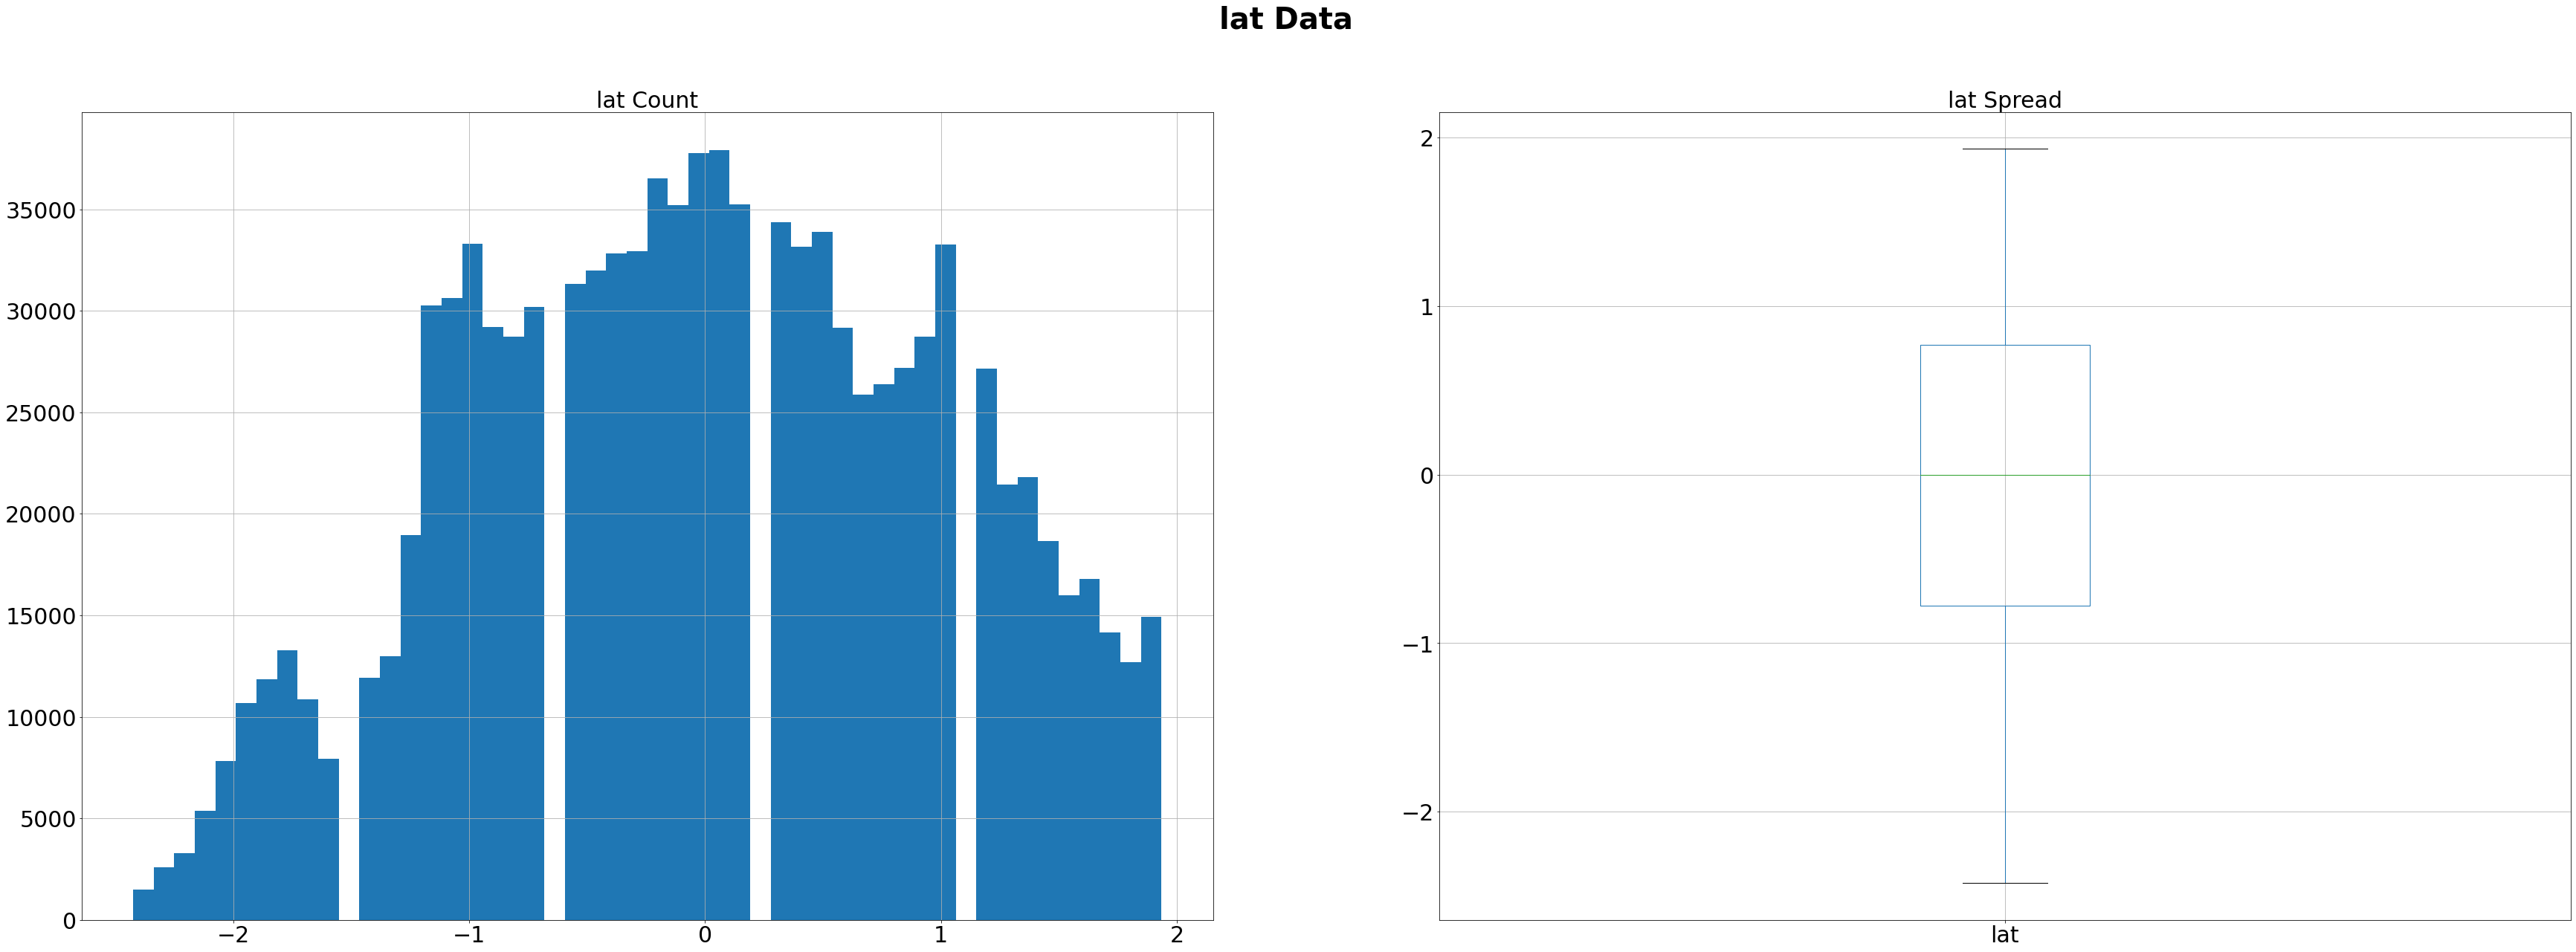

In [111]:
Normality_Check('lat')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


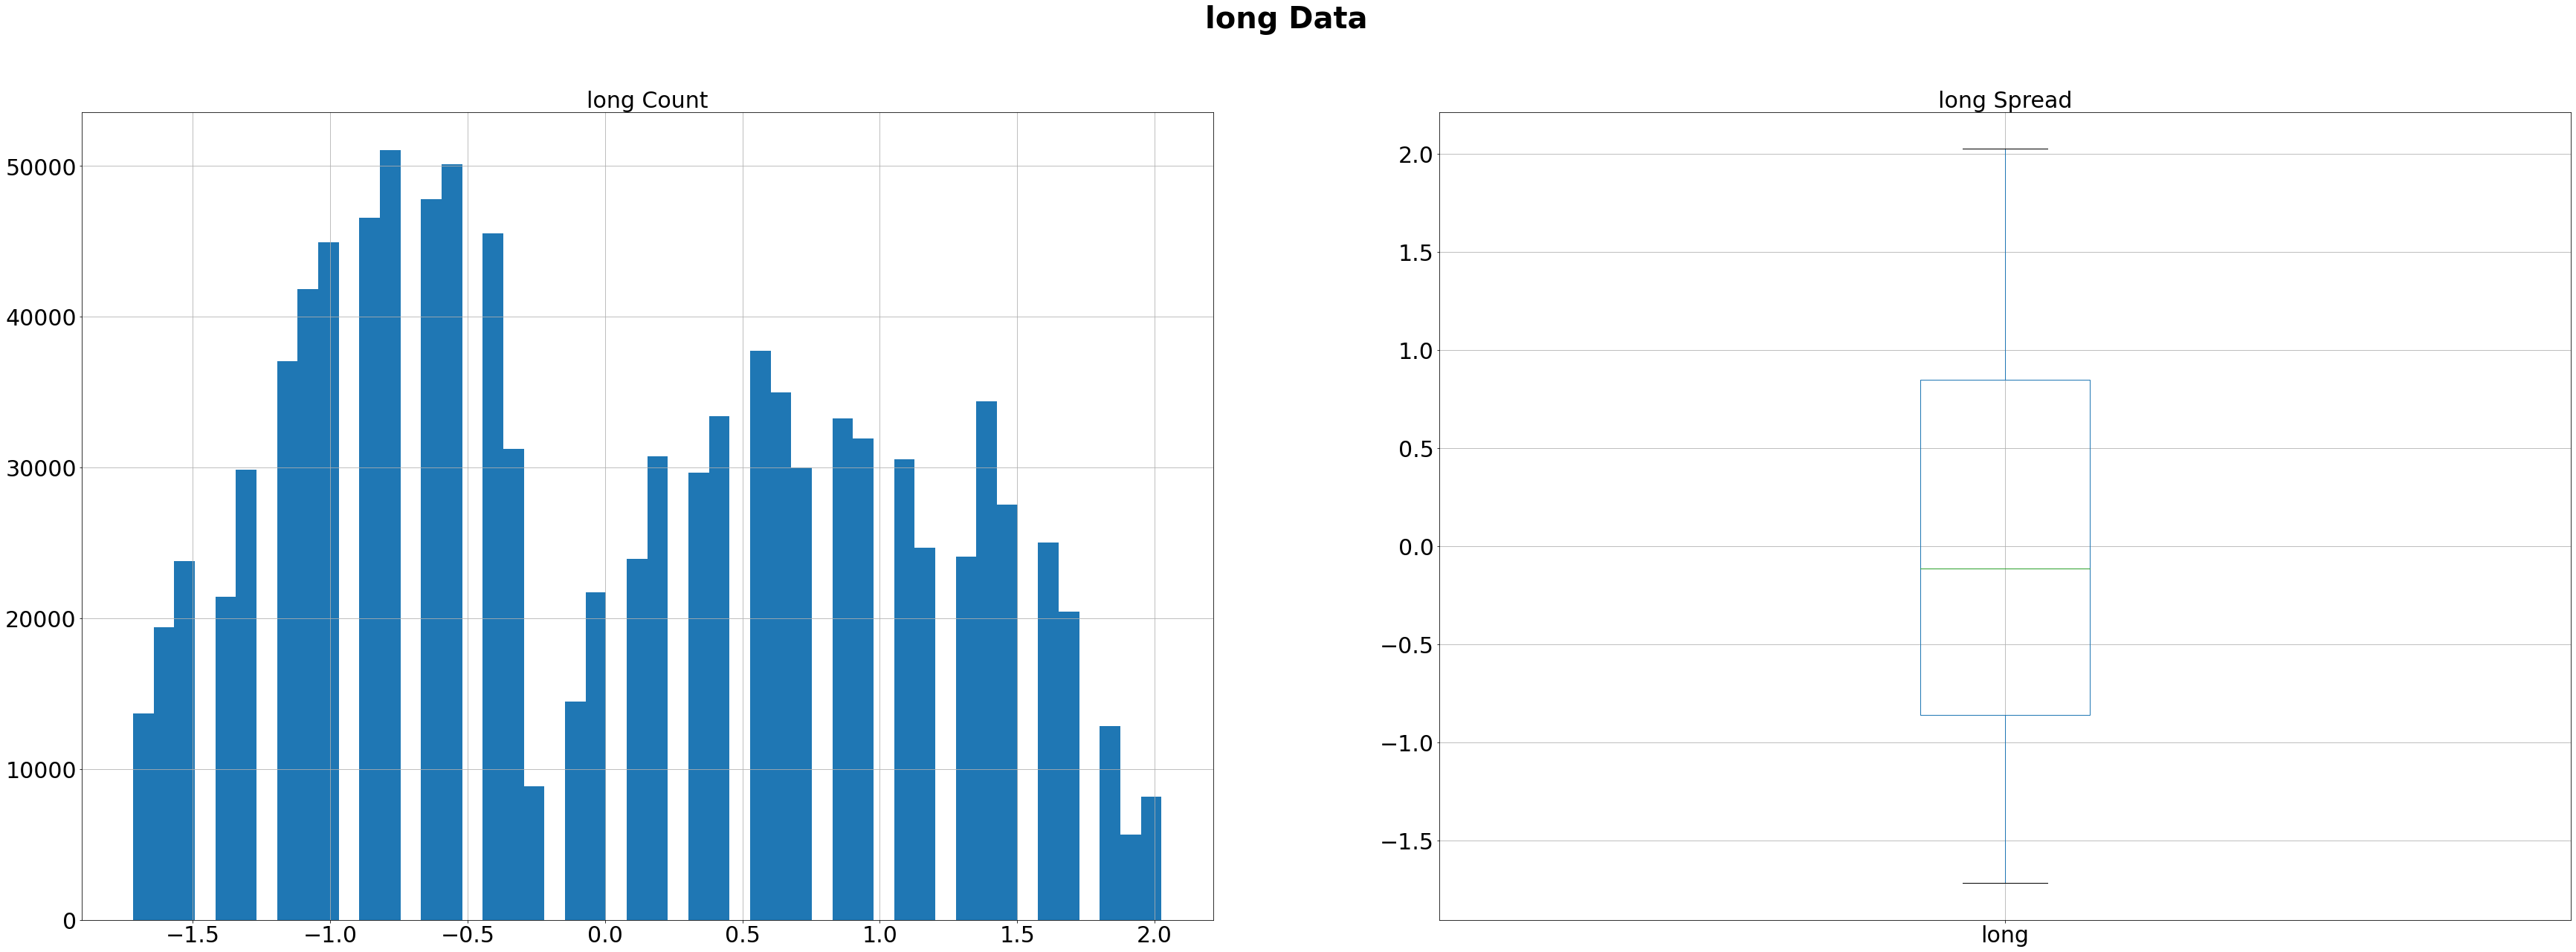

In [112]:
Normality_Check('long')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


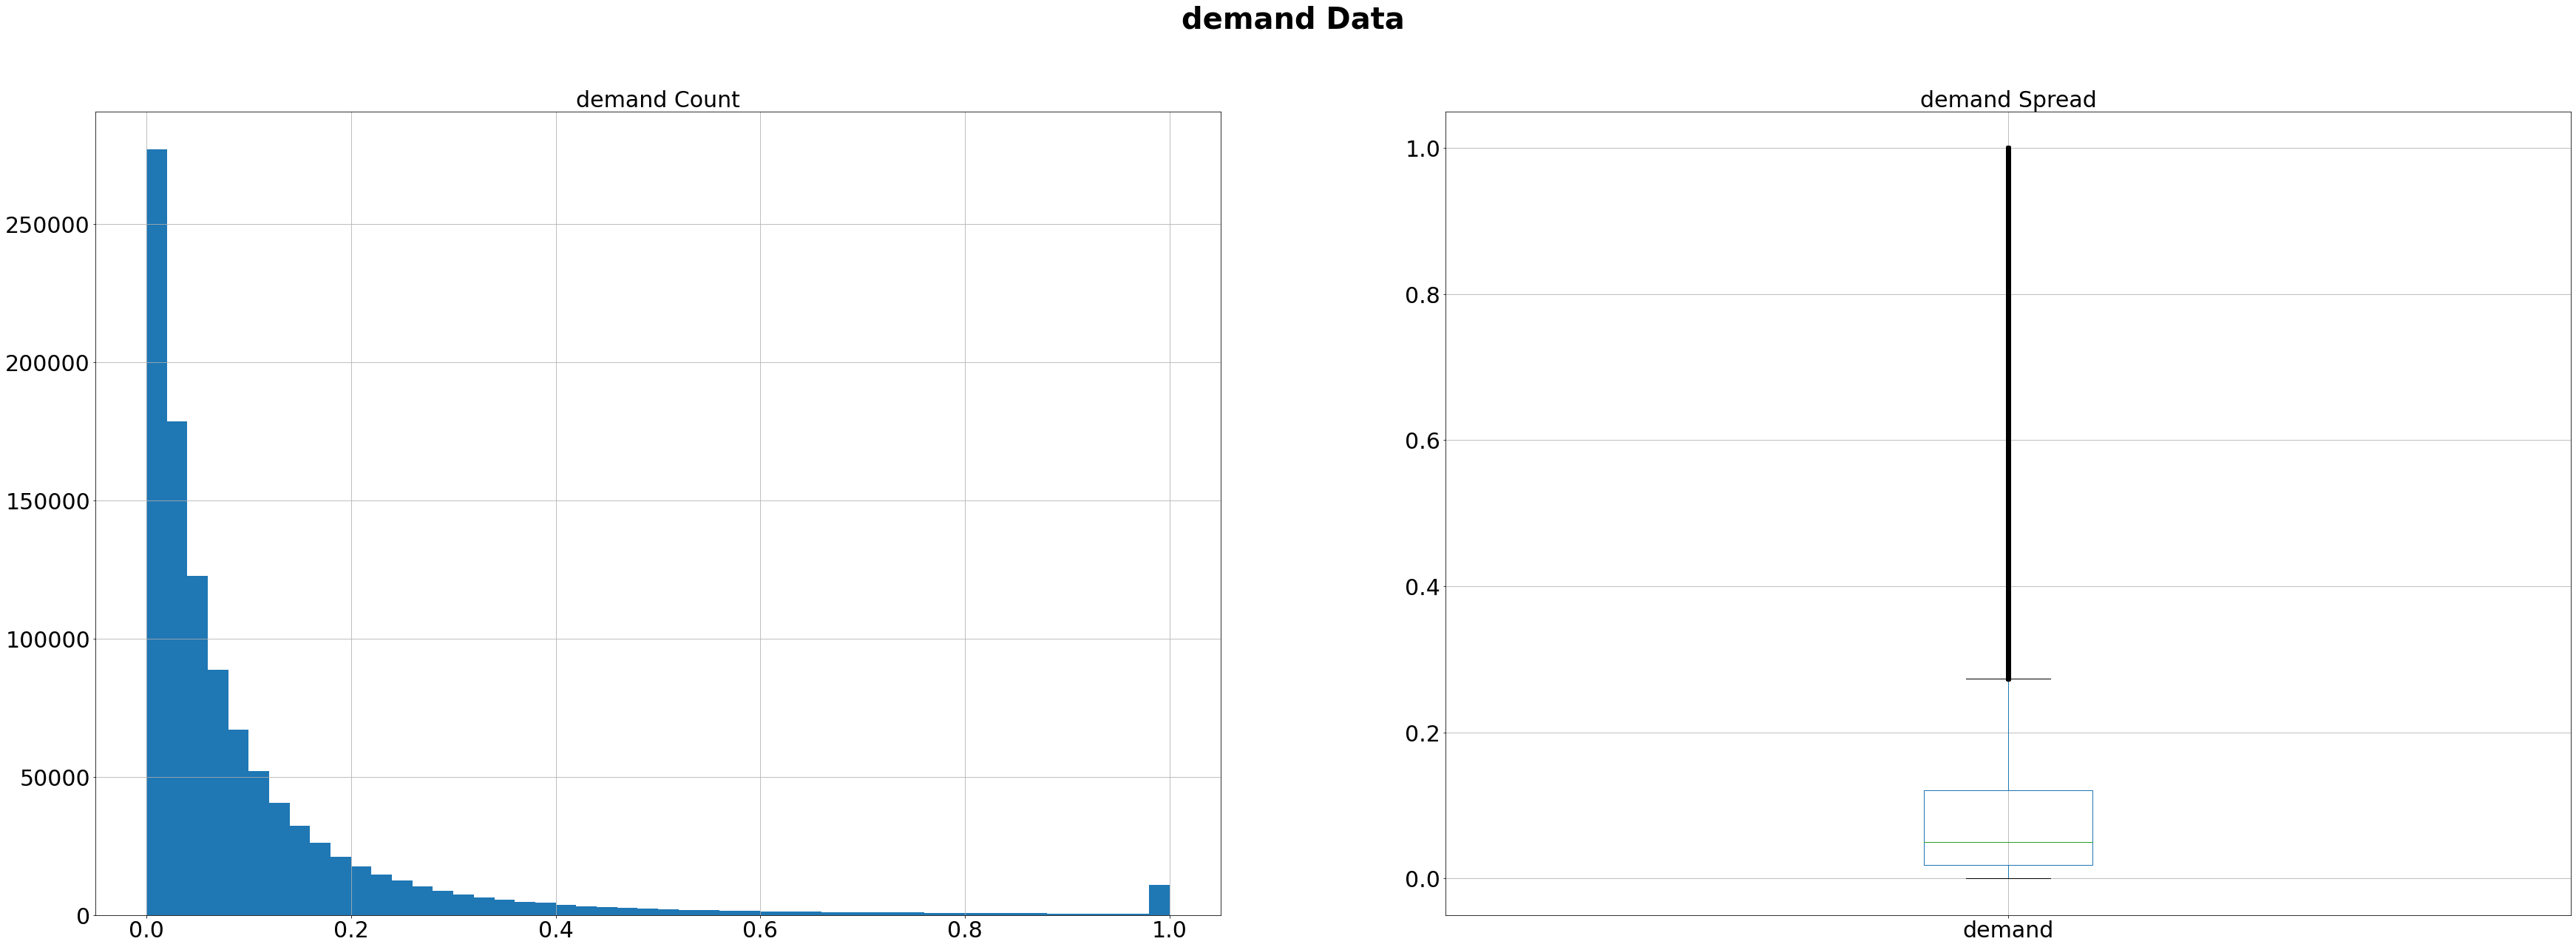

In [113]:
Normality_Check('demand')

In [126]:
# transform LoanAMount
df['demand_log'] = np.log(df['demand'])

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


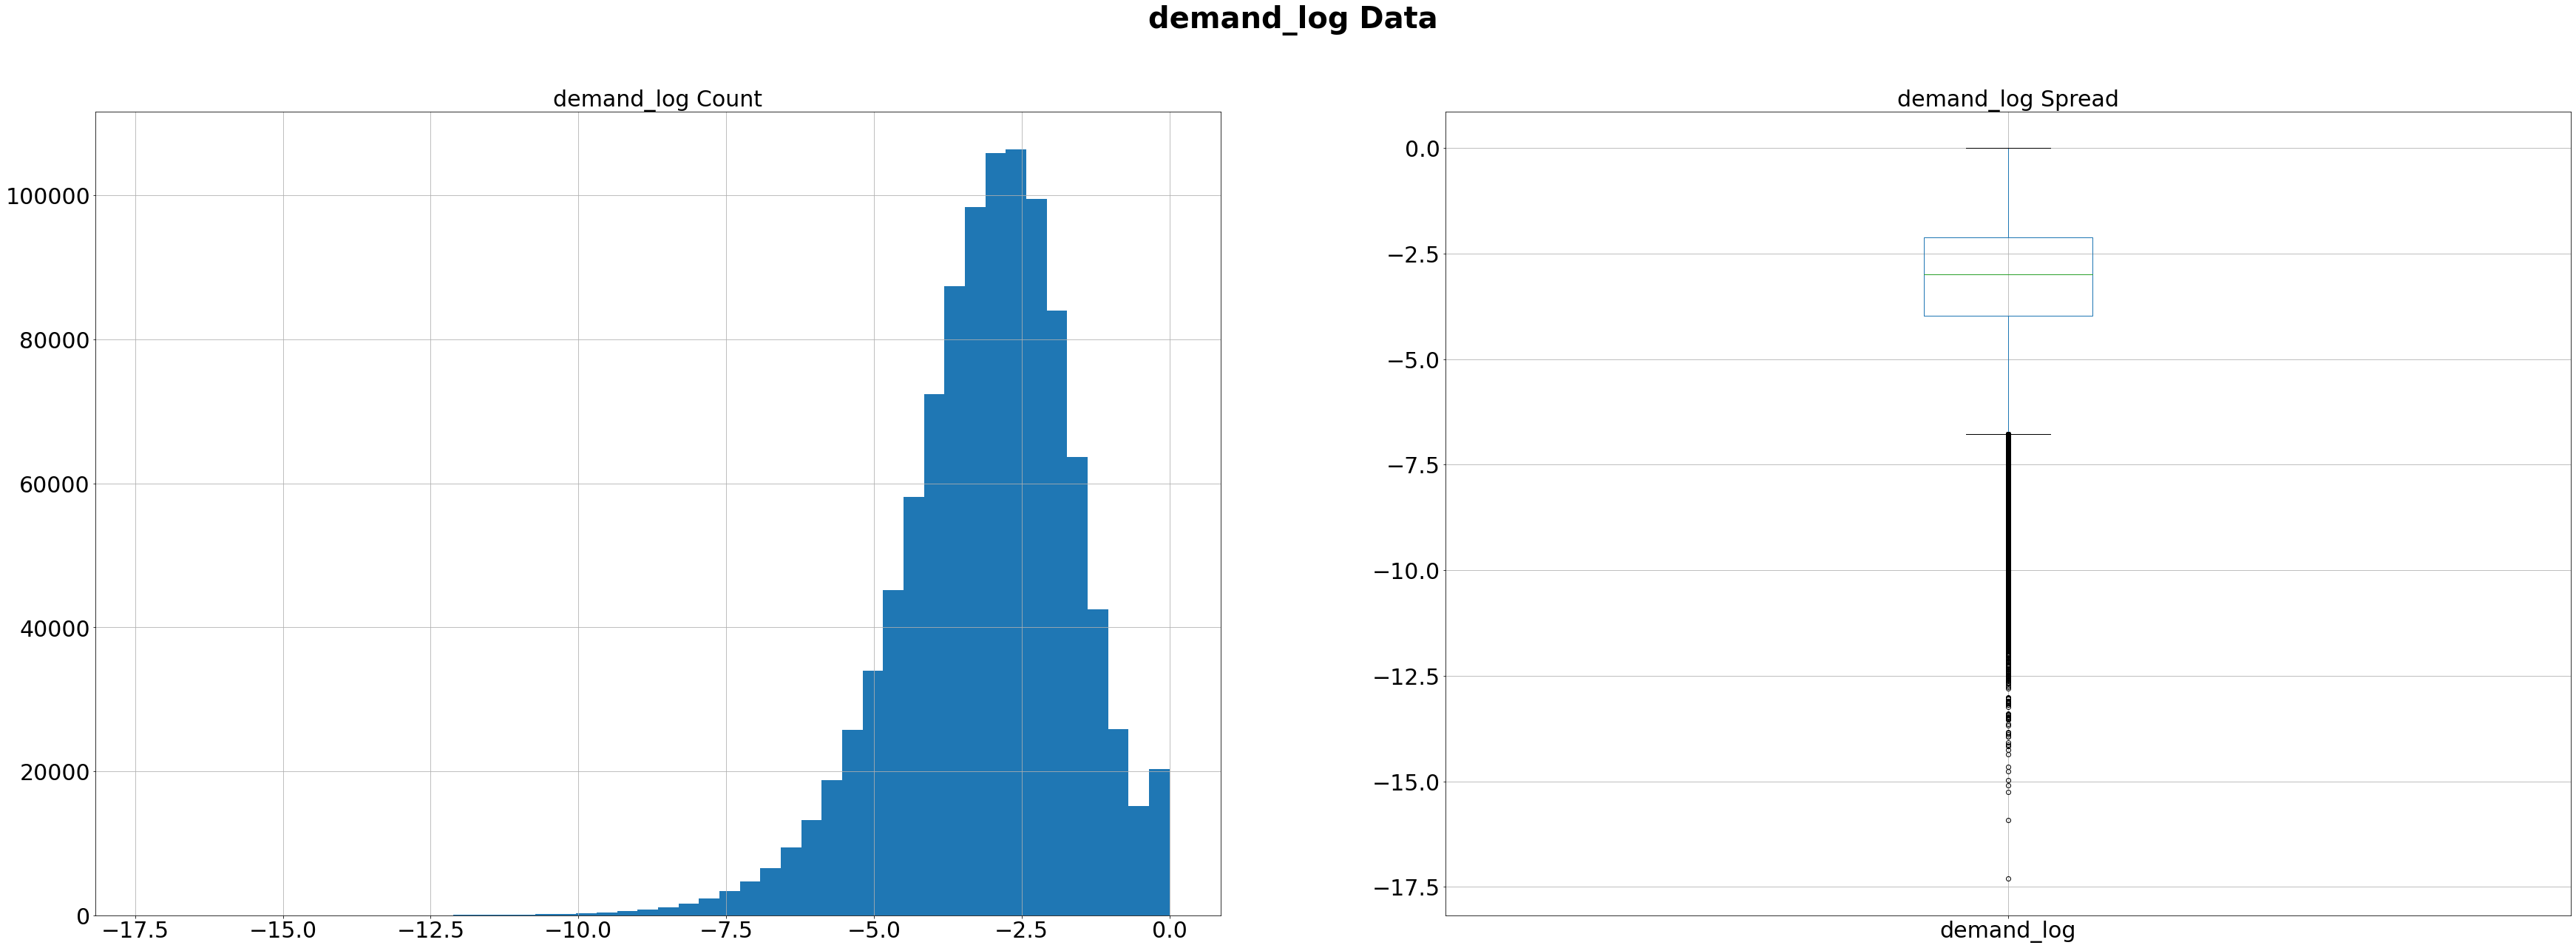

In [127]:
Normality_Check('demand_log')

#### Create a new excel workbook

In [120]:
writer = pd.ExcelWriter('data/Dataset_feature_sorted_normalised_log.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='TrafficMgmt', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()
